In [2]:
import geopandas as gpd
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [ ]:
# data = gpd.read_file('all_parcels.geojson') # takes about 2 minutes to load. Very long, not good for interface

In [ ]:
# data['geom_area_sqft'] = data.geometry.area # area of parcel geoms

In [ ]:
# data.to_parquet('test.parquet')
# data = gpd.read_parquet('test.parquet') # putting it to a parquet makes the data load much faster! 

# Loading Data

In [2]:
# with open('data.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('data.pkl', 'rb') as f: # pickling is also much faster than regular load geojson
    data = pickle.load(f)

In [ ]:
# marta_stops  = gpd.read_file('MARTA_Stops.geojson') # im thinking the stops are more useful since i can then do a calculation for HOW FAR the parcels are from the nearest stop
# marta_stops.to_crs(epsg=2240, inplace=True)

In [3]:
with open('marta.pkl', 'rb') as f: # pickling is also much faster than regular load geojson
    marta_stops = pickle.load(f)

In [ ]:
# all_roads = gpd.read_file(r"C:\Code\cake-database\roads.geojson")
# roads = all_roads[all_roads['RTTYP'] == 'S'].reset_index() # https://www.census.gov/library/reference/code-lists/route-type-codes.html
# roads.to_crs(epsg=2240, inplace=True)

In [4]:
with open('roads.pkl', 'rb') as f: 
    roads = pickle.load(f)

https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-georgia-primary-and-secondary-roads-state-based-shapefile

# Adding simplified RCI

In [ ]:
data['RCI'] = data['ClassCode'].str[0] # takes the classcode and only returns the first letter category

In [ ]:
data['RCI'].value_counts()

https://atlantabuildingbenchmarking.wordpress.com/compliance/state-property-codes/

# Land Value Ratio

In [ ]:
data['land_value_ratio'] = np.nan # preallocating the column
mask = data['LandAcres'] != 0 # avoiding div by 0 errors by making a mask, could use other methods but this is easier to read
data.loc[mask, 'land_value_ratio'] = data.loc[mask, 'LandAppr'] / (data.loc[mask, 'LandAcres'] * 43560) # dollars per sqft

- It seems that the LandAcres variable may only track the area of the land excluding any buildings. 
- There are problems where some parcels are not their true size but are small squares to represent places within buildings
- Therefore, neither LandAcres or geom_area_sqft is correct but I will go with the LandAcres variable since that was originally in the dataset

# Making desireability metrics

In [ ]:
r_weights = { 
    'R': 60,  
    'C': 30,   
    'E': 10,  # exempt areas can include things like libraries
}

c_weights = {
    'R' : 20,
    'C' : 50,
    'I' : 30
}

i_weights = {
  'I' : 40,
  'C' : 40,
  'B' : 15, # brownfield polluted areas
  'A' : 5   # agricultural areas
}

def normalize_residential_reuse_metric(parcels_within_buffer):
    """
    Calculate the normalized desirability score for residential reuse
    based on land use weights within a buffer area.
    
    Args:
        parcels_within_buffer (GeoDataFrame): GeoDataFrame containing parcels with land use codes.

    Returns:
        float: Normalized desirability score between 0 and 1.
    """
    total_weight = 0
    max_weight = 0  

    for _, row in parcels_within_buffer.iterrows():
        land_use_code = row['RCI']
        total_weight += r_weights.get(land_use_code, 0)
        max_weight += r_weights['R']
    
    desirability_score = total_weight / max_weight
    return desirability_score

def normalize_commercial_reuse_metric(parcels_within_buffer):
    """See the residential docstring"""
    total_weight = 0
    max_weight = 0  

    for _, row in parcels_within_buffer.iterrows():
        land_use_code = row['RCI']
        total_weight += c_weights.get(land_use_code, 0)
        max_weight += c_weights['C']
    
    desirability_score = total_weight / max_weight
    return desirability_score

def normalize_industrial_reuse_metric(parcels_within_buffer):
    """See the residential docstring"""
    total_weight = 0
    max_weight = 0 

    for _, row in parcels_within_buffer.iterrows():
        land_use_code = row['RCI']
        total_weight += i_weights.get(land_use_code, 0)
        max_weight += i_weights['I']
    
    desirability_score = total_weight / max_weight
    return desirability_score

def distance_metric(distance, max_distance = 2500, cutoff = 500):
    """
    Calculate a distance-based metric with penalties for exceeding a maximum distance.

    Args:
        distance (float): The distance to evaluate.
        max_distance (float, optional): Maximum distance before penalty. Defaults to 2500.
        cutoff (float, optional): Distance below which the metric is maximized. Defaults to 500.

    Returns:
        float: A metric value based on the distance, ranging from 1 to a penalty value.
    """
    if distance <= cutoff:
        return 1  
    elif distance > max_distance:
        penalty = -np.log((distance - max_distance))/10 # adjust penalty here
        return penalty  
    else:
        return 1 - (distance - cutoff) / (max_distance - cutoff)

# Filtering Data

In [8]:
vacant_r_query = data['LUCode'] == '100' # vacant residential
vacant_a_query = data['LUCode'] == '200' # vacant apartment
vacant_c_query = data['LUCode'] == '300' # vacant commercial
vacant_i_query = data['LUCode'] == '400' # vacant industrial
vacant_e_query = data['LUCode'] == '600' # vacant exempt
vacant_u_query = data['LUCode'] == '700' # vacant utility

# Select a dataset to work on

In [ ]:
subset = data[vacant_r_query] # the residential vacancies take about an hour to run! be careful
subset.shape

(19730, 10)

In [ ]:
for i in range(subset.shape[0]):
    try:
        specific_data = subset.iloc[[i]]                    # grabbing a particular row
        specific_geom = specific_data.geometry.iloc[0]      # getting the geometry from that row
        buffer_geom = specific_geom.buffer(1000)            # looking at parcels within 1000ft of the parcel of interest
        buffer_mask = data.geometry.intersects(buffer_geom) # getting mask for parcels that intersect with the buffer
        parcels_within_buffer = data[buffer_mask]           # getting parcels that intersect with the buffer
        subset.loc[subset.index[i],'r_reuse'] = normalize_residential_reuse_metric(parcels_within_buffer) # calculating residential weight around parcel of interest
        subset.loc[subset.index[i],'c_reuse'] = normalize_commercial_reuse_metric(parcels_within_buffer)  # calculating commercial weight around parcel of interest
        subset.loc[subset.index[i],'i_reuse'] = normalize_industrial_reuse_metric(parcels_within_buffer)  # calculating industrial weight around parcel of interest

        distances = marta_stops.geometry.distance(specific_geom)    # getting distances from each marta stop
        nearest_busstop_index = distances.idxmin()                  # getting the nearest busstop index
        nearest_busstop = marta_stops.iloc[nearest_busstop_index]   # the nearest busstop
        nearest_distance = distances.min()                          # the smallest distance
        subset.loc[subset.index[i],'walkability'] = distance_metric(nearest_distance, max_distance = 2500, cutoff = 500) # distance metric

        road_distanes = roads.geometry.distance(specific_geom) # getting distances from each road
        nearest_road_index = road_distanes.idxmin()            # getting the nearest road index
        nearest_road = roads.iloc[nearest_road_index]          # the nearest road
        nearest_distance = road_distanes.min()                 # the smallest distance
        subset.loc[subset.index[i],'drivability'] = distance_metric(nearest_distance, max_distance = 15000, cutoff = 1000) # distance metric

        # median-normalied LVAR
        subset.loc[subset.index[i],'land_value_ratio'] = specific_data['land_value_ratio'].iloc[0] / parcels_within_buffer['land_value_ratio'].median()

        area = specific_geom.area                                                # area of parcel
        perimeter = specific_geom.length                                         # perimeter of parcel
        subset.loc[subset.index[i],'shape_factor'] = 4*np.pi*area/(perimeter**2) # assigning the shape factor
        
    except Exception as e:
        print(f"Error processing index {i}: {e}")
        continue

result = subset.copy()

c:\Users\Adrian\miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Adrian\miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Adrian\miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [22]:
result['total'] = 0*result['land_value_ratio'] + result['r_reuse'] + result['walkability'] + result['drivability'] + result['shape_factor']
result.nlargest(10,'total')

,ParcelID,TotAppr,LandAppr,LUCode,ClassCode,LandAcres,geometry,geom_area_sqft,RCI,land_value_ratio,r_reuse,c_reuse,i_reuse,walkability,drivability,shape_factor,total
295841,13 0132 LL3371,276600,276600,300,C3,1.0160,"POLYGON ((2204288.065 1302500.595, 2204295.707...",43823.015469,C,0.534884,0.971374,0.434351,0.057252,1.0,1.0,0.837775,3.809149
295836,13 0132 LL3397,643300,643300,300,C3,1.2420,"POLYGON ((2204331.128 1303113.270, 2204333.590...",54133.746334,C,1.031961,0.961712,0.445946,0.076577,1.0,1.0,0.844148,3.805860
295842,13 0132 LL3363,251700,251700,300,C3,1.0290,"POLYGON ((2204314.892 1302308.225, 2204307.829...",45389.626039,C,0.479459,0.973881,0.431343,0.052239,1.0,1.0,0.830522,3.804403
60491,22 527010472757,924100,924100,300,C3,0.8670,"POLYGON ((2264990.269 1491421.925, 2264966.284...",36900.909069,C,0.805187,0.975501,0.425835,0.044543,1.0,1.0,0.808930,3.784431
131199,17 0076 LL0152,2911500,2911500,300,C4,6.4700,"POLYGON ((2235813.250 1441050.750, 2235811.250...",354566.648319,C,0.199377,0.973870,0.410593,0.027542,1.0,1.0,0.806800,3.780670
122750,17 010600068954,1316700,1305900,300,C3,1.3452,"POLYGON ((2231843.157 1377654.310, 2231875.000...",34086.667436,C,0.442353,0.984587,0.412783,0.024025,1.0,1.0,0.785359,3.769946
288840,13 0132 LL0229,370300,370300,300,C3,1.7000,"POLYGON ((2204684.446 1302522.839, 2204684.480...",70467.016654,C,0.418113,0.975758,0.429091,0.048485,1.0,1.0,0.784343,3.760101
31109,12 192404171324,649000,649000,300,C3,0.6030,"POLYGON ((2238221.240 1457691.980, 2238219.856...",25593.439214,C,0.749455,0.959649,0.431579,0.061053,1.0,1.0,0.792886,3.752536
146007,17 009300030363,287700,287700,300,C3,0.0653,"POLYGON ((2232031.179 1415772.372, 2232029.140...",28442.286820,C,3.055547,0.959040,0.442797,0.074947,1.0,1.0,0.783517,3.742556
228249,14 0252 LL0767,265100,265100,300,C3,1.5100,"POLYGON ((2194626.386 1340549.365, 2194866.171...",64688.855369,C,0.095194,0.955761,0.435802,0.067901,1.0,1.0,0.780057,3.735818


In [ ]:
# with open('result.pkl', 'wb') as f: # storing result
#     pickle.dump(result, f)

# The following has the development of the metrics and preliminary results

# Looking at surrounding land usage

In [51]:
specific_data = subset.iloc[[1234]]  
specific_geom = specific_data.geometry.iloc[0]

buffer_geom = specific_geom.buffer(1000)  # looking at parcels within 1000ft of the parcel of interest

buffer_mask = data.geometry.intersects(buffer_geom)
parcels_within_buffer = data[buffer_mask]

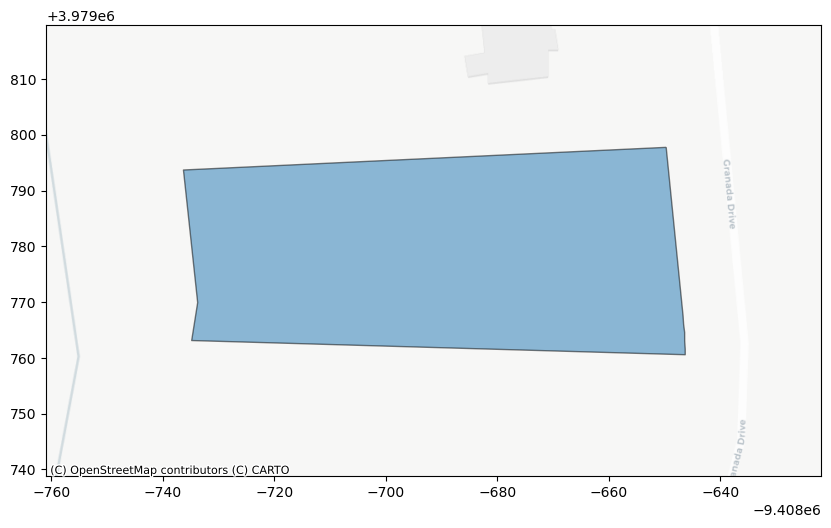

In [52]:
toplot = specific_data.to_crs(epsg=3857)
ax = toplot.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# Increase these ranges to show a larger area around the data
ax.set_xlim(x_min - 20, x_max + 20)
ax.set_ylim(y_min - 20, y_max + 20)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

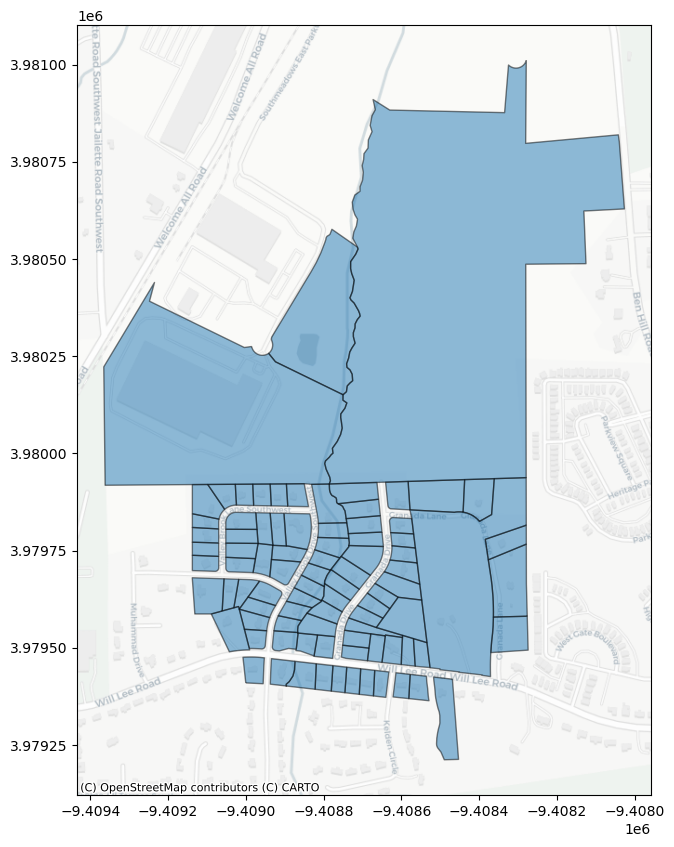

In [64]:
toplot = parcels_within_buffer.to_crs(epsg=3857)
ax = toplot.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# Increase these ranges to show a larger area around the data
ax.set_xlim(x_min - 1, x_max + 1)
ax.set_ylim(y_min - 1, y_max + 1)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [53]:
print(normalize_residential_reuse_metric(parcels_within_buffer))
print(normalize_commercial_reuse_metric(parcels_within_buffer))
print(normalize_industrial_reuse_metric(parcels_within_buffer))

0.9655172413793104
0.41839080459770117
0.04597701149425287


# MARTA distance

- Metric for how close it is to the nearest MARTA stop

- https://arc-garc.opendata.arcgis.com/datasets/coaplangis::marta-stops/about

In [65]:
distances = marta_stops.geometry.distance(specific_data.geometry.iloc[0])

In [79]:
nearest_busstop_index = distances.idxmin()
nearest_busstop = marta_stops.iloc[[nearest_busstop_index]]
nearest_distance = distances.min()
print(f"The nearest bus stop is {nearest_busstop['stop_name'].iloc[0]} with a distance of {nearest_distance:.02f} {data.crs.axis_info[0].unit_name}.")

The nearest bus stop is WELCOME ALL RD @ 4345 with a distance of 2346.48 US survey foot.


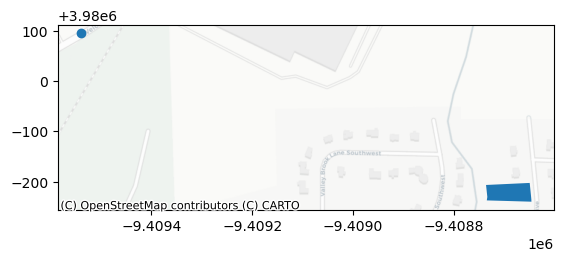

In [84]:
fig, ax = plt.subplots()
nearest_busstop.to_crs(epsg=3857).plot(ax=ax)
specific_data.to_crs(epsg=3857).plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [80]:
distance_metric(nearest_distance, max_distance = 2500, cutoff = 500)

0.07675860555239711

# Road Accessibility Score

In [85]:
road_distanes = roads.geometry.distance(specific_data.geometry.iloc[0])
nearest_road_index = road_distanes.idxmin()  
nearest_road = roads.iloc[[nearest_road_index]]
nearest_distance = road_distanes.min()
nearest_distance

5769.100239263174

In [86]:
distance_metric(nearest_distance, max_distance = 15000, cutoff = 1000) # driving metric

0.6593499829097733

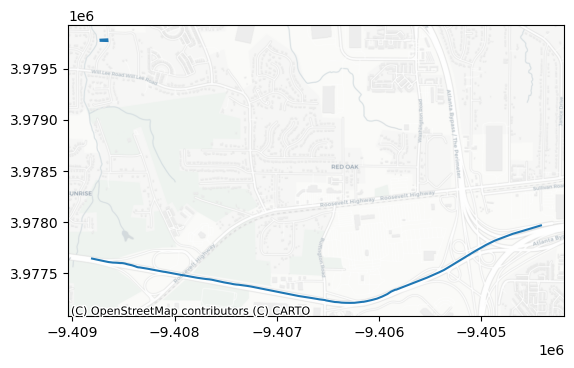

In [87]:
fig, ax = plt.subplots()
nearest_road.to_crs(epsg=3857).plot(ax=ax)
specific_data.to_crs(epsg=3857).plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Looking at value of land

In [59]:
specific_data['LandAppr'].iloc[0] / parcels_within_buffer['LandAppr'].median()

1.0229885057471264

In [60]:
specific_data['land_value_ratio'].iloc[0] / parcels_within_buffer['land_value_ratio'].median()

0.9473475753149986

# Shape factor

In [61]:
area = specific_data.iloc[0].geometry.area
perimeter = specific_data.iloc[0].geometry.length
4*np.pi*area/(perimeter**2)

0.6249489371335558